In [62]:
from pathlib import Path

import cv2
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader
from torchlake.common.datasets.images import ImageDataset
from torchlake.common.network import FeatureExtractor, ImageNormalization
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.image import load_image, save_img_array
from torchlake.common.utils.plot import plot_grids
from torchlake.style_transfer.models import (FastStyleTransfer,
                                             NeuralStyleTransferLoss)
from torchvision import transforms
from tqdm import tqdm

# setting

In [63]:
artifacts_path = Path('../../artifacts/fast-style-transfer')
data_path = Path('../../data/VOCdevkit/**/JPEGImages/*.jpg')
content_path = Path('../../data/contents')
style_path = Path('../../data/styles')

In [64]:
device = torch.device('cuda:0')

In [65]:
CONTENT_LAYER_NAMES = ['2_1']
STYLE_LAYER_NAMES = ['1_1','2_1','3_1','4_1']

In [66]:
IMAGE_SIZE = 224
CONTENT_WEIGHT = 1e1
STYLE_WEIGHT = 5e5
BATCH_SIZE = 16

In [67]:
transform_x = transforms.Compose([
  transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
  transforms.ToTensor()  
])

In [68]:
transform_y = transforms.Compose([
  transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
  transforms.ToTensor()  
])

# dataset

In [69]:
dataset = ImageDataset(data_path.as_posix(), transform_x)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [70]:
len(dataset)

27088

In [74]:
style = (
    transform_y(Image.open(style_path.joinpath("starry.jpg")))
    .repeat(BATCH_SIZE, 1, 1, 1)
    .to(device)
)

# model

In [71]:
feature_extractor = FeatureExtractor('vgg16', 'relu', device)

In [72]:
model = FastStyleTransfer().to(device)

# start transfer

In [73]:
LR = 1e-4
EPOCHES = 3

In [75]:
criterion = NeuralStyleTransferLoss(1, CONTENT_WEIGHT, STYLE_WEIGHT)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [76]:
for e in range(EPOCHES):
    content_score, style_score = 0, 0
    optimizer.zero_grad()
    model.train()

    for content in tqdm(dataloader):
        content = content.to(device)
        generated = model(content)

        with torch.no_grad():
            content_feature = feature_extractor(content, CONTENT_LAYER_NAMES)[0]
            style_features = feature_extractor(style, STYLE_LAYER_NAMES)
        generated_features = feature_extractor(generated, STYLE_LAYER_NAMES)

        loss, content_loss, style_loss = criterion(
            content_feature, style_features, generated_features
        )
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        content_score += content_loss.item()
        style_score += style_loss.item()

    print(
        f"epoch: {e+1},",
        f"content loss: {content_score / len(dataset)},",
        f"style loss: {style_score / len(dataset)}",
    )

100%|██████████| 1693/1693 [10:04<00:00,  2.80it/s]


epoch: 1, content loss: 0.24967362777023575, style loss: 1.4005238779842497e-05


100%|██████████| 1693/1693 [10:03<00:00,  2.81it/s]


epoch: 2, content loss: 0.23557968506324384, style loss: 2.6132879731596262e-06


100%|██████████| 1693/1693 [10:28<00:00,  2.70it/s]

epoch: 3, content loss: 0.220513285288991, style loss: 1.87661786480541e-06


In [77]:
model_path = artifacts_path.joinpath(f'starry.{CONTENT_WEIGHT:.0e}.{STYLE_WEIGHT:.0e}.pth')

In [78]:
torch.save(model.state_dict(), model_path.as_posix())

In [84]:
model.load_state_dict(torch.load(model_path.as_posix()))
model = model.to(device)

# visualize

In [85]:
content_img = load_image(content_path.joinpath('vacation-hotel.jpg').as_posix(), is_tensor=True)
style_img = load_image(style_path.joinpath('starry.jpg').as_posix(), is_numpy=True) # demo

In [81]:
model.eval()
with torch.no_grad():
    normalization = ImageNormalization()
    content_norm = normalization(content_img).unsqueeze(0).to(device)
    output = model(content_norm)

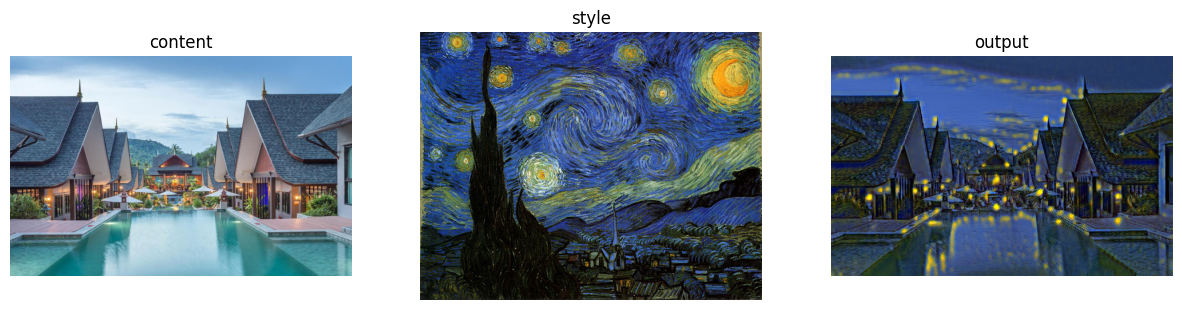

In [87]:
plot_grids(
    [img_tensor_to_np(content_img), style_img, img_tensor_to_np(output).clip(0, 1)],
    ['content', 'style', 'output'],
    1,
    3,
    figsize=(15, 10),
)

In [83]:
save_img_array(img_tensor_to_np(output.squeeze())[:,:,::-1], artifacts_path.joinpath('output.jpg').as_posix())

# video

In [ ]:
model_path = artifacts_path.joinpath('sketch.pth')

In [93]:
model.load_state_dict(torch.load(model_path))

In [94]:
vid = cv2.VideoCapture(artifacts_path.joinpath("cat.mp4"))

num_frame = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
frame_h = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_w = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
fps = vid.get(5)

fourcc = cv2.VideoWriter_fourcc(*"XVID")
vid_writer = cv2.VideoWriter(
    artifacts_path.joinpath("output.avi"), fourcc, fps, (frame_w, frame_h // 2)
)

In [95]:
# placeholder = []
for i in tqdm(range(num_frame)):
    ret, frame = vid.read()
    if not ret:
        break

    frame = cv2.resize(frame, (frame_w // 2, frame_h // 2))

    frame = frame.astype(np.float32)
    frame = frame / 255
    # placeholder.append(frame)

    # if len(placeholder) == 2:
    # batch_frame = np.stack(placeholder)
    batch_frame = torch.from_numpy(frame).unsqueeze_(0).permute(0, 3, 1, 2).to(device)
    batch_frame = normalization(batch_frame)

    model.eval()
    with torch.no_grad():
        output = model(batch_frame)
        output = output.permute(0, 2, 3, 1).clamp(0, 1).detach().cpu().numpy()

    # release memory
    # batch_frame = batch_frame.permute(0,2,3,1).detach().cpu().numpy()

    compare_list = np.concatenate([np.expand_dims(frame, 0), output], axis=2) * 255
    # for compare in compare_list:
    vid_writer.write(compare_list[0].astype(np.uint8).clip(0, 255))
    # if i == 1000: break

100%|██████████| 2936/2936 [01:18<00:00, 37.39it/s]


In [96]:
vid_writer.release()
vid.release()